In [1]:
#Generating Neccessary Functions 
import numpy as np
from PIL import Image
import cv2
import glob
from scipy import interpolate
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
import os
from pathlib import Path

from ripser import ripser 
from persim import plot_diagrams
from sklearn.decomposition import PCA

#topological data analysis
from persim import plot_diagrams
from dreimac import CircularCoords 
from dreimac import CircleMapUtils as CMU

#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline  

In [2]:
def introduction(): 
    intro = '''Welcome to our Topological Decoupling Simulation!  This simulation aims to apply a chain of algorithms 
    that, when given a quasi-periodic video with N independent oscillations, rearranges the frames in N different 
    ways such that for the nth video created, the nth oscillation will be in motion while the others remain 
    stationary. We achieve this by applying the a sliding-window algorithm to provided video data to extract 
    quasi-periodocity. We also make use of PCA for visualization purposes, ripser to detect persistent cohomology, 
    and the DREiMac algorithm to apply circular coordinates.  
    For our simulation, we ask that you provide the following:
    '''
    print(intro)
    global N, videofp, WindowSize, Dimension, SampleSize, PCA_Components
    N=int(input("Number of Oscillations present in video data: "))
    while N <= 0: 
        print("Please input a valid non-negative integer greater than zero")
        N=int(input("Number of Oscillations present in video data: ")) 
            
    videofp=input("Please provide the file path to your video (if you have a sequence of images but no video," 
                 " input 'images'): ")
    if videofp=='images': 
        videofp=input("Please provide the file path to folder containing image sequence: ")
    WindowSize=int(input("Window Size (a size of 15-18 is recommended): "))
    Dimension=int(input("Sliding window dimension (a dimension of 3-5 is recommended): "))
    SampleSize=int(input("Sample Size (size of Sliding Window sample, 300-500 is recommended): "))
    PCA_Components=int(input("Number of components for PCA: "))
    
    

In [3]:
introduction()

Welcome to our Topological Decoupling Simulation!  This simulation aims to apply a chain of algorithms 
    that, when given a quasi-periodic video with N independent oscillations, rearranges the frames in N different 
    ways such that for the nth video created, the nth oscillation will be in motion while the others remain 
    stationary. We achieve this by applying the a sliding-window algorithm to provided video data to extract 
    quasi-periodocity. We also make use of PCA for visualization purposes, ripser to detect persistent cohomology, 
    and the DREiMac algorithm to apply circular coordinates.  
    For our simulation, we ask that you provide the following:
    
Number of Oscillations present in video data: 2
Please provide the file path to your video (if you have a sequence of images but no video, input 'images'): /Users/slmathuser/Documents/GitHub/TTSA-Project-3/dots_quasi.wmv
Window Size (a size of 15-18 is recommended): 18
Sliding window dimension (a dimension of 3-5 

In [4]:
#Generating Video Functions 
def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))
        f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X

def writeVideo(filename, frame_data, fps, resol ):
    n_row, n_col = resol
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (n_col, n_row))
    if frame_data.dtype !='uint8':
        frame_data -= np.amin(frame_data)
        frame_data *= 255/np.amax(frame_data)
        frame_data = np.uint8(frame_data)
    for frame in frame_data:
        out.write(frame.reshape((n_row, n_col,-1)))
    out.release()
def playVideo(filepath):
    cap = cv2.VideoCapture(filepath)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('frame', frame)
        if cv2.waitKey(24) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()  

def loadVideo(filepath):
    vid = cv2.VideoCapture(filepath)
    _, image = vid.read()
    count = 0
    success = True
    global n_row, n_col
    n_row, n_col, _ = image.shape 
    data = []
    while success:
        data.append(image.flatten()) 
        success,image = vid.read()
        count += 1
    vid.release() 
    data = np.array(data)
    print(count, " frames extracted")
    print("frame size = ", (n_row , n_col))
    print("data shape =", data.shape)
    return data , (n_row, n_col)

In [5]:
#Storing Video Data into Data Variable
data, shape = loadVideo(videofp)

390  frames extracted
frame size =  (100, 200)
data shape = (390, 60000)


In [6]:
#Performing Sliding Window Algorithm 
wSize = WindowSize
dim = Dimension
Tau = wSize/float(dim)
desiredSamples=SampleSize
M = data.shape[0] - wSize + 1
dT = M/float(desiredSamples)
X = getSlidingWindowVideo(data, dim, Tau, dT)

XS = X - np.mean(X, 1)[:, None]
XS = XS/np.sqrt(np.sum(XS**2, 1))[:, None]

#X = X - np.amin(X)
#X = X/np.amax(X)
#X = np.uint8(*255)
frame_data = X[:, 0:data.shape[1]]


/var/folders/cy/j26w4bs96qx4s7nvml4d4hdm0000gp/T/ipykernel_73730/1586172474.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
/var/folders/cy/j26w4bs96qx4s7nvml4d4hdm0000gp/T/ipykernel_73730/1586172474.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBiva

In [7]:
print(X.shape)

(997, 300000)


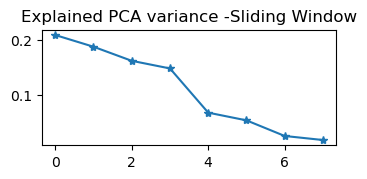

In [8]:
# PCA of the Sliding window point cloud
pca = PCA(n_components=PCA_Components)
XS_pca = pca.fit(XS).transform(XS)
plt.figure(figsize = (3.8,1.5))
plt.plot(pca.explained_variance_ratio_, '-*') ;
plt.title('Explained PCA variance -Sliding Window');


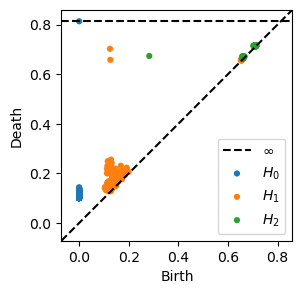

In [9]:
# Compute persistence diagrams of the pca vesion of the sliding window point cloud
res = ripser(XS_pca, maxdim=2, n_perm =int(0.75*SampleSize), coeff =13, thresh = 0.9)
dgms = res['dgms']
plt.figure(figsize = (3,3)) 
plot_diagrams(dgms)

In [ ]:
n_lands = int(0.75*SampleSize)

cc = CircularCoords(XS, n_landmarks=n_lands)

plot_diagrams(cc.dgms_)


/Users/slmathuser/anaconda3/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


In [ ]:
# Get the circular coordinates at birth, and for the N/2 or N/3 cocycles with highest persistence
coho_classes=[]

for i in range(N): 
    coho_classes.append(i)

circular_coords = []

for i in coho_classes:
    #perc: specifies the time in filtration to construct the coordinates 
    #cocyle_index: Picks a persistent homology class when the classes are ordered with respect to persistence
    theta = cc.get_coordinates(perc= 0, cocycle_idx=i)
    theta = CMU.to_sinebow(np.pi + CMU.center(theta))
    circular_coords.append(theta)



In [ ]:
# Plot data with N circular coordinates

fig = make_subplots(rows=1, cols=len(coho_classes), 
                    subplot_titles = tuple('Circ Coord '+str(i+1) for i in coho_classes),
                    specs = [[{'type': 'scatter3d'} for i in coho_classes]])

for i, coord in enumerate(circular_coords):
    fig.add_trace(
        go.Scatter3d(x=XS_pca[:,0], y=XS_pca[:,1], z=XS_pca[:,2],   mode ='markers', 
        marker=dict(size = 2 , color =  circular_coords[i])),  
        row=1, col=i+1)
    fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
                      yaxis=dict( ticks='', showticklabels=False), 
                      zaxis=dict( ticks='', showticklabels=False), 
                      aspectmode='data', row=1, col=i+1)

fig.update_layout( showlegend=False )
fig.show()


In [ ]:
#Gathering Angle Values Corresponding to Cohomology Classes
thetavals=[]
for i in range(len(circular_coords)):
    list=[]
    for j in range(len(circular_coords[i])): 
        theta=np.arctan2(circular_coords[i][j][1], circular_coords[i][j][0])
        list.append(theta)
    thetavals.append(list)
    
thetavals=np.array(thetavals)

In [ ]:
#Sorting Data based on Theta Values
# Pair the elements from all matrices
angle_pairs = np.column_stack([thetas.flatten() for thetas in thetavals])

# Sort the pairs based on lexicographic order
#sorted_indices = np.lexsort([angle_pairs[:, i] for i in range(N)])



In [ ]:
#Extract the columns from the matrix
col1 = angle_pairs[:, 0]
col2 = angle_pairs[:, 1]

# Sort the matrices based on the respective column
sortedidx1 = np.argsort(col1)
sorted_m1 = angle_pairs[sortedidx1]

sortedidx2 = np.argsort(col2)
sorted_m2 = angle_pairs[sortedidx2]

In [ ]:
X1=X[sortedidx1]
X2=X[sortedidx2]

In [ ]:
#Averaging Overlapping Windows 
first_elements=[]
overlap_indices=[]

for i in range(len(X)): 
    sublist=[] 
    overlap_flag=False 
    for j in range(len(X1[i])): 
        sublist.append(X1[i][j])
        if not overlap_flag:
            if sublist.count(X1[i][j]) > 1:
                overlap_indices.append(j)
                overlap_flag = True
    first_elements.append(sublist)

In [ ]:
# Find the index where the overlapping elements end
overlap_end = max(overlap_indices)

# Calculate the average of the overlapping elements
overlap_avg = np.mean([sublist[:overlap_end] for sublist in first_elements], axis=0)

# Iterate over each sublist and replace the overlapping elements with the average
for sublist in first_elements:
    sublist[:overlap_end] = overlap_avg

In [ ]:
# Create fl as a list with each row containing 20,000 sub-sublists of size 3
fl = []
for sublist in first_elements:
    sublist_chunks = [sublist[i:i+3] for i in range(0, len(sublist), 3)]
    fl.extend(sublist_chunks[:(n_row*n_col)])

# Reshape fl to have the desired shape (*depends on desired samples*, 20000, 3)
fl_reshaped = np.array(fl).reshape((X.shape[0], (n_row*n_col), 3))


In [ ]:
writeVideo("pilot.mp4", fl_reshaped, 10, (n_row,n_col))